### Install SECANT from GitHub
##### - Before running, make sure runtime has been set to GPU

In [ ]:
!pip install git+https://github.com/tarot0410/SECANT.git -q
!pip install umap-learn

     |████████████████████████████████| 86 kB 4.3 MB/s 
     |████████████████████████████████| 1.1 MB 64.2 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.2-py3-none-any.whl size=82708 sha256=8b8475ec311a5dbb1d91343f69679ae774d4e5fd1cf4d3b99b080ea6914db1a8
  Stored in directory: /root/.cache/pip/wheels/84/1b/c6/aaf68a748122632967cef4dffef68224eb16798b6793257d82
  Created wheel for pynndescent: filename=pynndescent-0.5.5-py3-none-any.whl size=52603 sha256=e8708e63b80a0fd59ae4aaba0fd513a161992746c68c5811e5148be98cc81dab
  Stored in directory: /root/.cache/pip/wheels/af/e9/33/04db1436df0757c42fda8ea6796d7a8586e23c85fac355f476
Successfully built umap-learn pynndescent


### Import packages

In [ ]:
from SECANT import SECANT as SE
import torch
import numpy as np
import pandas as pd
import umap
import matplotlib.pyplot as plt

### Mount Google Drive for accessing external data

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

### Joint analyzing 10X10k_PBMC (CITE-seq) and 10X5k_PBMC (mimic scRNA-seq) data

In [ ]:
url = 'https://raw.githubusercontent.com/tarot0410/SECANT/main/real_data/Joint_10X/'
### Load in ADT confident cell type label
# ADT data from 10X10k (CITE-seq input)
ADT_df0 = pd.read_csv(url + 'label_10X10k.csv')
ADT_Lbl0 = SE.df_to_tensor(ADT_df0)[:,0]   
ADT_Lbl0 = ADT_Lbl0 - 1 # make sure values in ADT_Lbl0 range from 0, and the maximum value refers to "uncertain" group
# Check uncertain rate in the given ADT label
print('P(uncertain|ADT0)=', round(sum(ADT_Lbl0.cpu().numpy()==int(torch.max(ADT_Lbl0)))/ADT_Lbl0.size(0),3))

# ADT data from 10X5k (mimic scRNA-seq input)
# labels are not used for fitting SECANT, but for assessing prediction performance only
ADT_df1 = pd.read_csv(url + 'label_10X5k.csv')
ADT_Lbl1 = SE.df_to_tensor(ADT_df1)[:,0]   
ADT_Lbl1 = ADT_Lbl1 - 1 # make sure values in ADT_Lbl1 range from 0, and the maximum value refers to "uncertain" group
# Check uncertain rate in the given ADT label
print('P(uncertain|ADT1)=', round(sum(ADT_Lbl1.cpu().numpy()==int(torch.max(ADT_Lbl1)))/ADT_Lbl1.size(0),3))

### Load in RNA data (after dimension reduction)
# RNA data from 10X10k
RNA_df0 = pd.read_csv(url + 'latent_10k.csv')
RNA_df0.drop(RNA_df0.columns[[0]], axis=1, inplace=True) # drop index column
data0 = SE.df_to_tensor(RNA_df0) # convert data matrix df to tensor
print('#cells|RNA0=', data0.size(0))
print('#features|RNA0=', data0.size(1))

# RNA data from 10X5k
RNA_df1 = pd.read_csv(url + 'latent_5k.csv')
RNA_df1.drop(RNA_df1.columns[[0]], axis=1, inplace=True) # drop index column
data1 = SE.df_to_tensor(RNA_df1) # convert data matrix df to tensor
print('#cells|RNA1=', data1.size(0))
print('#features|RNA1=', data1.size(1))

P(uncertain|ADT0)= 0.163
P(uncertain|ADT1)= 0.115
#cells|RNA0= 7865
#features|RNA0= 10
#cells|RNA1= 5527
#features|RNA1= 10


### Visualization of pooled RNA data after batch effect correction

In [ ]:
# Set up UMAP
N0 = data0.size()[0]
N1 = data1.size()[0]
data_pool = torch.cat((data0, data1), 0)
batchLbl = np.concatenate((np.zeros(N0), np.ones(N1)))

In [ ]:
reducer = umap.UMAP(random_state=42)
embedding0 = reducer.fit_transform(data_pool.cpu())

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


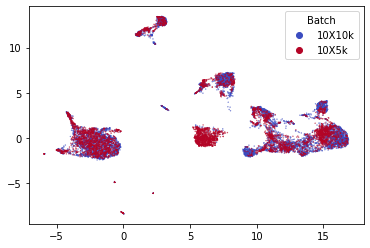

In [ ]:
scatter0 = plt.scatter(embedding0[:, 0],
            embedding0[:, 1],
            c=batchLbl, s=0.1, cmap='coolwarm')
mylabel0=('10X10k', '10X5k')
legend0 = plt.legend(handles=scatter0.legend_elements()[0],labels=mylabel0,loc="best", title="Batch", fontsize="medium")

### Run SECANT

In [ ]:
### Input one configuration of concordance matrix
# Example: {B:2; CD14+ Mono:2; CD4+ T:3; CD8+ T:3; NK:1}
# Determine based on prior knowledge or data-driven (check 'Search_Best_Config' section)
concordance_config = [2,2,3,3,1] 

### Main function to run SECANT
SE_rslt = SE.SECANT_JOINT(data0, data1, concordance_config, ADT_Lbl0)

### Core outputs
# predicted confident cell type for 10X5k (mimic scRNA-seq data)
ADT_type_predict = SE_rslt.lbl_predict
# cluster labels
lbl0 = SE_rslt.lbl0 # for 10X10k (CITE-seq input)
lbl1 = SE_rslt.lbl1 # for 10X5k (scRNA-seq input)
# concordance matrix
conMtxFinal = SE_rslt.conMtxFinal 
# cluster weights
wgt0 = SE_rslt.wgt0_out
wgt1 = SE_rslt.wgt1_out
# posterior probability of ADT confident cell type prediction (for 10X5k)
preditADT_postP = SE_rslt.preditADT_post
# final converged log-likelihood
logLik_final = SE_rslt.logLik_final 

### Estimated distribution parameters
# cluster-specific mean vector
mu_out = SE_rslt.mu_out
# cluster-specific covariance matrix
scale_out = SE_rslt.scale3D_out
scale_out_t = scale_out.permute(0,2,1)
cov_out = scale_out @ scale_out_t

### Check SECANT results

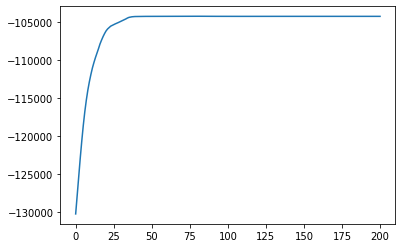

In [ ]:
### Check convergence of log-likelihoods
# log-likelihoods across all iterations
logLik_vec = SE_rslt.logLikVec 
logLik_vec_final = logLik_vec[logLik_vec != 0] 
plt.plot(logLik_vec_final)

In [ ]:
### Concordance matrix and cluster weights (new)
print('Concordance matrix:')
print(np.around(conMtxFinal.cpu().data.numpy(),3))
print('')
print('Cluster weights_data0:')
print(np.around(wgt0.cpu().data.numpy(),3))
print('')
print('Cluster weights_data1:')
print(np.around(wgt1.cpu().data.numpy(),3))

Concordance matrix:
[[0.962 0.328 0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.177 0.874 0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.831 0.986 0.903 0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.763 0.871 0.767 0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.876]
 [0.038 0.672 0.823 0.126 0.169 0.014 0.097 0.237 0.129 0.233 0.124]]

Cluster weights_data0:
[0.067 0.04  0.05  0.227 0.006 0.158 0.155 0.05  0.053 0.075 0.119]

Cluster weights_data1:
[0.059 0.029 0.08  0.201 0.202 0.144 0.128 0.004 0.02  0.07  0.064]


In [ ]:
# show confusion matrix
confTab = pd.crosstab(ADT_type_predict.cpu().data.numpy(), ADT_Lbl1.cpu().numpy(),
                      rownames = ["predict"], colnames = ["observed"])
print(confTab)
confMtx = np.array(confTab)
subMtx = confMtx[0:-1, 0:-1]
subMtx2 = confMtx[:, 0:-1]
accuracy = np.diagonal(subMtx).sum() / subMtx2.sum()

print("")
print("Accuracy (excluding observed uncertain group)=", accuracy)

observed  0.0   1.0   2.0  3.0  4.0  5.0
predict                                 
0         305     0     0    0    0   26
1           1  1086    19    0    0   29
2           0    33  2350  124    4  116
3           0     0    65  336    1  109
4           1     0    11    7  280   60
5          22   187    42    4   12  297

Accuracy (excluding observed uncertain group)= 0.8910020449897751
